<a href="https://colab.research.google.com/github/fikrinotes/LSTM-IDS/blob/main/Final_Project_IDS_with_Autoencoder_and_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

dataset_path = kagglehub.dataset_download('chethuhn/network-intrusion-dataset')
model_path = kagglehub.dataset_download('fikrimulyanasetiawan/rnn-model')
encoder_path = kagglehub.dataset_download('fikrimulyanasetiawan/encoder')

print('Data source import complete.')


100%|██████████| 5.05M/5.05M [00:00<00:00, 126MB/s]

Extracting files...


100%|██████████| 233k/233k [00:00<00:00, 100MB/s]

Extracting files...
Data source import complete.


In [4]:
print(dataset_path)

/kaggle/input/network-intrusion-dataset


# Intrusion Detection System

## Import Library

In [5]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


## Preprocessing Data

In [6]:
# Fungsi untuk membaca dan preprocessing setiap file
def read_and_clean_file(file_path):
    print(f"Membaca file: {file_path}")
    df = pd.read_csv(file_path, low_memory=False, sep=",")

    # Bersihkan nama kolom dari whitespace
    df.columns = df.columns.str.strip()

    # Hapus kolom yang tidak diperlukan
    redundant = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP',
                 'Destination Port', 'Protocol', 'Timestamp']
    df = df.drop(redundant, axis=1, errors='ignore')

    # drop baris yang tidak punya label
    df.dropna(subset = ['Label'], inplace=True)

    # Handling missing values dan infinite values
    df = df.replace([np.inf, -np.inf], np.nan)

    return df


# Baca semua file CSV dari folder
folder_path = '/kaggle/input/network-intrusion-dataset'
data1 = dataset_path + "/Monday-WorkingHours.pcap_ISCX.csv"
data2 = dataset_path + "/Tuesday-WorkingHours.pcap_ISCX.csv"
data3 = dataset_path + "/Wednesday-workingHours.pcap_ISCX.csv"
data4 = dataset_path + "/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"
data5 = dataset_path + "/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"
data6 = dataset_path + "/Friday-WorkingHours-Morning.pcap_ISCX.csv"
data7 = dataset_path + "/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"
data8 = dataset_path + "/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"


# Baca semua file CSV dari folder
all_files = [data2, data3, data4, data5, data6, data7, data8]

# Membaca file dan mengkonversi data file menjadi dataframe
dataframes = []
for file in all_files:
    # file_path = os.path.join(folder_path, file)
    df = read_and_clean_file(file)
    dataframes.append(df)

Membaca file: /kaggle/input/network-intrusion-dataset/Tuesday-WorkingHours.pcap_ISCX.csv
Membaca file: /kaggle/input/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv
Membaca file: /kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Membaca file: /kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Membaca file: /kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv
Membaca file: /kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Membaca file: /kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv


In [7]:
# Menggabungkan semua dataframe
print("Menggabungkan semua file...")
df = pd.concat(dataframes, ignore_index=True)
try:
    print("Semua file dataset berhasil digabungkan!")
except:
    print("Error! file dataset tidak berhasil digabungkan")

Menggabungkan semua file...
Semua file dataset berhasil digabungkan!


In [8]:
dataframe = df.copy(deep=True)

In [9]:
dataframe['Label'] = dataframe['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [10]:
df.columns

Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PS

In [11]:
corr_matrix = dataframe.corr(method='pearson')

In [15]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)

In [12]:
corr_matrix

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
Flow Duration,1.000000,0.020364,0.019064,0.059987,0.015570,0.267670,-0.102557,0.144402,0.232109,0.509018,...,-0.000509,0.185997,0.229857,0.285030,0.122846,0.785934,0.246418,0.797915,0.755633,0.220949
Total Fwd Packets,0.020364,1.000000,0.999014,0.299808,0.996279,0.008333,-0.002797,0.000045,0.001317,0.021515,...,-0.000204,0.025222,0.008646,0.021702,0.024526,0.001544,0.000729,0.001628,0.001403,-0.003994
Total Backward Packets,0.019064,0.999014,1.000000,0.292893,0.993421,0.008018,-0.002395,-0.000306,0.000975,0.021261,...,0.000018,0.024381,0.006684,0.019872,0.024676,0.001067,0.000383,0.001093,0.000983,-0.004071
Total Length of Fwd Packets,0.059987,0.299808,0.292893,1.000000,0.286435,0.188771,0.001248,0.179182,0.153514,0.016942,...,-0.001144,0.089001,0.100854,0.117999,0.056370,0.021069,0.025934,0.024353,0.017235,-0.018832
Total Length of Bwd Packets,0.015570,0.996279,0.993421,0.286435,1.000000,0.005640,-0.002047,-0.001423,-0.000483,0.020807,...,0.000016,0.020636,0.003714,0.015556,0.021634,0.000532,0.000050,0.000521,0.000516,-0.002766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Idle Mean,0.785934,0.001544,0.001067,0.021069,0.000532,0.183587,-0.073711,0.129071,0.185753,0.589125,...,0.000039,0.115003,0.028509,0.082847,0.115132,1.000000,0.145399,0.990188,0.990035,0.391023
Idle Std,0.246418,0.000729,0.000383,0.025934,0.000050,0.183044,-0.029483,0.182426,0.195580,0.170847,...,-0.003131,0.067039,0.074826,0.065295,0.038139,0.145399,1.000000,0.280096,0.005252,0.104504
Idle Max,0.797915,0.001628,0.001093,0.024353,0.000521,0.202869,-0.075749,0.150259,0.206710,0.594131,...,-0.000430,0.127680,0.047357,0.096772,0.119982,0.990188,0.280096,1.000000,0.961025,0.394776
Idle Min,0.755633,0.001403,0.000983,0.017235,0.000516,0.158606,-0.069921,0.104471,0.159475,0.570767,...,0.000506,0.104990,0.016454,0.071809,0.109640,0.990035,0.005252,0.961025,1.000000,0.381063


In [13]:
# Korelasi setiap fitur dengan label
target_corr = corr_matrix['Label'].abs().sort_values(ascending=False)

# Pilih fitur dengan korelasi > threshold (misal: top 20%)
threshold = 0.05  # Ambang minimal korelasi
high_corr_features = target_corr[target_corr > threshold].index.tolist()

# Hapus 'Label' jika termasuk
high_corr_features = [f for f in high_corr_features if f != 'Label']

print(f"Selected features: {len(high_corr_features)}")
print(high_corr_features)

Selected features: 38
['Bwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Avg Bwd Segment Size', 'Packet Length Std', 'Max Packet Length', 'Packet Length Variance', 'Fwd IAT Std', 'Packet Length Mean', 'Average Packet Size', 'Idle Max', 'Idle Mean', 'Flow IAT Max', 'Fwd IAT Max', 'Idle Min', 'Flow IAT Std', 'Min Packet Length', 'Bwd Packet Length Min', 'Fwd IAT Total', 'Flow Duration', 'Flow IAT Mean', 'FIN Flag Count', 'PSH Flag Count', 'Fwd IAT Mean', 'URG Flag Count', 'Bwd IAT Std', 'Fwd Packet Length Min', 'ACK Flag Count', 'Bwd IAT Max', 'Idle Std', 'Init_Win_bytes_backward', 'Avg Fwd Segment Size', 'Fwd Packet Length Mean', 'SYN Flag Count', 'Fwd PSH Flags', 'Fwd Packet Length Max', 'Down/Up Ratio', 'Flow Packets/s']


In [14]:
# Buat matriks korelasi hanya untuk fitur terpilih
high_corr_df = dataframe[high_corr_features]
feature_corr = high_corr_df.corr().abs()

# Identifikasi pasangan fitur dengan korelasi tinggi
to_drop = set()
for i in range(len(feature_corr.columns)):
    for j in range(i):
        if feature_corr.iloc[i, j] > 0.8:  # Threshold multikolinearitas
            col_i = feature_corr.columns[i]
            col_j = feature_corr.columns[j]

            # Bandingkan korelasi dengan target, hapus yang lebih rendah
            if target_corr[col_i] > target_corr[col_j]:
                to_drop.add(col_j)
            else:
                to_drop.add(col_i)

# Final feature selection
final_features = [f for f in high_corr_features if f not in to_drop]

print(f"\nFinal features after multicollinearity check: {len(final_features)}")
print(final_features)


Final features after multicollinearity check: 17
['Bwd Packet Length Std', 'Fwd IAT Std', 'Min Packet Length', 'Bwd Packet Length Min', 'Flow IAT Mean', 'FIN Flag Count', 'PSH Flag Count', 'URG Flag Count', 'Bwd IAT Std', 'Fwd Packet Length Min', 'ACK Flag Count', 'Idle Std', 'Init_Win_bytes_backward', 'Avg Fwd Segment Size', 'SYN Flag Count', 'Down/Up Ratio', 'Flow Packets/s']


In [15]:
df.describe()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,...,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06,2.300825e+06
mean,1.579823e+07,9.124129e+00,1.013505e+01,5.531908e+02,1.576287e+04,2.114469e+02,1.835353e+01,5.991961e+01,7.154907e+01,9.778951e+02,...,4.958900e+00,-2.540647e+03,8.457227e+04,4.065386e+04,1.549771e+05,6.163359e+04,9.433560e+06,5.732621e+05,9.864630e+06,8.990073e+06
std,3.460566e+07,7.127588e+02,9.522747e+02,1.067420e+04,2.156969e+06,7.657296e+02,6.461895e+01,2.015989e+02,3.038008e+02,2.111330e+03,...,5.755252e+02,1.173879e+06,6.618916e+05,3.925080e+05,1.025175e+06,5.935032e+05,2.532916e+07,4.995685e+06,2.611131e+07,2.506222e+07
min,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.470000e+02,1.000000e+00,1.000000e+00,6.000000e+00,2.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,2.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.132200e+04,2.000000e+00,2.000000e+00,6.000000e+01,1.200000e+02,3.600000e+01,2.000000e+00,3.300000e+01,0.000000e+00,7.700000e+01,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.582168e+06,5.000000e+00,4.000000e+00,1.870000e+02,5.680000e+02,8.100000e+01,3.500000e+01,4.928571e+01,2.327660e+01,3.220000e+02,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.200000e+08,2.079640e+05,2.846020e+05,1.290000e+07,6.270000e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.049469e+03,1.953000e+04,...,1.986360e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [16]:
df['Label']

,Label
0,BENIGN
1,BENIGN
2,BENIGN
3,BENIGN
4,BENIGN
...,...
2300820,BENIGN
2300821,BENIGN
2300822,BENIGN
2300823,BENIGN


### Pembersihan data duplikat

In [17]:
# ganti nama kolom dengan cara hapus whitespaces
col_names = {col: col.strip() for col in df.columns}
df.rename(columns = col_names, inplace = True)

# informasi data duplikat
dups = df[df.duplicated()]
print(f'Number of duplicates: {len(dups)}')

Number of duplicates: 524101


In [18]:
df.shape

(2300825, 78)

In [19]:
# Hapus data duplikat
df.drop_duplicates(inplace = True)
df.shape

(1776724, 78)

## Informasi Umum Dataset

In [20]:
# Menampilkan informasi dataset
print("\nInformasi Dataset:")
print(f"\nJumlah total data: {len(df)}")
print(f"Jumlah fitur : {len(df.columns)}")
print("\nDistribusi Label sebelum preprocessing:")

# tabel distribusi label
def create_distribution_table(df):
    label_dist = pd.DataFrame(df['Label'].value_counts())
    label_dist['percentage'] = df['Label'].value_counts()/len(df)
    return label_dist

create_distribution_table(df)


Informasi Dataset:

Jumlah total data: 1776724
Jumlah fitur : 78

Distribusi Label sebelum preprocessing:


,count,percentage
Label,,
BENIGN,1440219,0.810604
DoS Hulk,172849,0.097285
DDoS,128016,0.072052
DoS GoldenEye,10286,0.005789
FTP-Patator,5933,0.003339
DoS slowloris,5385,0.003031
DoS Slowhttptest,5228,0.002942
SSH-Patator,3219,0.001812
PortScan,1958,0.001102


In [21]:
df["Label"] = df["Label"].where(df["Label"] == "BENIGN", "ANOMALY")

In [22]:
df["Label"].unique()

array(['BENIGN', 'ANOMALY'], dtype=object)

In [23]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,640,7,4,440,358,220,0,62.857143,107.349008,179,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,900,9,4,600,2944,300,0,66.666667,132.287566,1472,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,1205,7,4,2776,2830,1388,0,396.571429,677.274651,1415,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,511,7,4,452,370,226,0,64.571429,110.276708,185,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,773,9,4,612,2944,306,0,68.000000,134.933317,1472,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2300812,4,2,0,0,0,0,0,0.000000,0.000000,0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2300814,22,1,1,0,0,0,0,0.000000,0.000000,0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2300816,45,1,1,0,0,0,0,0.000000,0.000000,0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2300823,48,2,0,12,0,6,6,6.000000,0.000000,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [24]:
# Menampilkan informasi dataset
print("\nInformasi Dataset:")
print(f"\nJumlah total data: {len(df)}")
print(f"Jumlah fitur : {len(df.columns)}")
print("\nDistribusi Label setelah preprocessing:")

create_distribution_table(df)


Informasi Dataset:

Jumlah total data: 1776724
Jumlah fitur : 78

Distribusi Label setelah preprocessing:


,count,percentage
Label,,
BENIGN,1440219,0.810604
ANOMALY,336505,0.189396


## Pemisahan Data Fitur (X) dan Ouput (y)

In [25]:
df[final_features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1776724 entries, 0 to 2300824
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Bwd Packet Length Std    float64
 1   Fwd IAT Std              float64
 2   Min Packet Length        int64  
 3   Bwd Packet Length Min    int64  
 4   Flow IAT Mean            float64
 5   FIN Flag Count           int64  
 6   PSH Flag Count           int64  
 7   URG Flag Count           int64  
 8   Bwd IAT Std              float64
 9   Fwd Packet Length Min    int64  
 10  ACK Flag Count           int64  
 11  Idle Std                 float64
 12  Init_Win_bytes_backward  int64  
 13  Avg Fwd Segment Size     float64
 14  SYN Flag Count           int64  
 15  Down/Up Ratio            int64  
 16  Flow Packets/s           float64
dtypes: float64(7), int64(10)
memory usage: 244.0 MB


In [26]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
X = df[final_features]
y = df["Label"]

In [27]:
X

,Bwd Packet Length Std,Fwd IAT Std,Min Packet Length,Bwd Packet Length Min,Flow IAT Mean,FIN Flag Count,PSH Flag Count,URG Flag Count,Bwd IAT Std,Fwd Packet Length Min,ACK Flag Count,Idle Std,Init_Win_bytes_backward,Avg Fwd Segment Size,SYN Flag Count,Down/Up Ratio,Flow Packets/s
0,103.345698,194.325157,0,0,64.000000,0,1,0,303.686242,0,0,0.0,2053,62.857143,0,0,17187.500000
1,849.859596,252.411229,0,0,75.000000,0,1,0,435.323252,0,0,0.0,2053,66.666667,0,0,14444.444440
2,816.950631,397.058392,0,0,120.500000,0,1,0,491.647231,0,0,0.0,2053,396.571429,0,0,9128.630705
3,106.809800,131.900594,0,0,51.100000,0,1,0,224.719826,0,0,0.0,2053,64.571429,0,0,21526.418790
4,849.859596,196.665733,0,0,64.416667,0,1,0,348.901132,0,0,0.0,2053,68.000000,0,0,16817.593790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2300812,0.000000,0.000000,0,0,4.000000,0,0,0,0.000000,0,1,0.0,-1,0.000000,0,0,500000.000000
2300814,0.000000,0.000000,0,0,22.000000,0,0,1,0.000000,0,1,0.0,3271,0.000000,0,1,90909.090910
2300816,0.000000,0.000000,0,0,45.000000,0,0,1,0.000000,0,1,0.0,501,0.000000,0,1,44444.444440
2300823,0.000000,0.000000,6,0,48.000000,0,0,0,0.000000,6,1,0.0,-1,6.000000,0,0,41666.666670


## Training-Test Split

In [28]:
tss = TimeSeriesSplit(n_splits=7)
print(tss)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=7, test_size=None)


In [29]:
#X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
train_index, test_index = [], []
for i, (train_interval, test_interval) in enumerate(tss.split(X)):
    print(f"fold {i}:")
    print(f"  Train: index : from {train_interval.min()} up to {train_interval.max()}")
    print(f"  Test:  index=from {test_interval.min()} up to {test_interval.max()}")
    print(f"  Jumlah kelas pada training set : {y.iloc[train_interval].nunique()}")
    print(f"  Jumlah kelas pada testing set : {y.iloc[test_interval].nunique()}")
    train_index, test_index = train_interval, test_interval


fold 0:
  Train: index : from 0 up to 222093
  Test:  index=from 222094 up to 444183
  Jumlah kelas pada training set : 2
  Jumlah kelas pada testing set : 2
fold 1:
  Train: index : from 0 up to 444183
  Test:  index=from 444184 up to 666273
  Jumlah kelas pada training set : 2
  Jumlah kelas pada testing set : 2
fold 2:
  Train: index : from 0 up to 666273
  Test:  index=from 666274 up to 888363
  Jumlah kelas pada training set : 2
  Jumlah kelas pada testing set : 2
fold 3:
  Train: index : from 0 up to 888363
  Test:  index=from 888364 up to 1110453
  Jumlah kelas pada training set : 2
  Jumlah kelas pada testing set : 2
fold 4:
  Train: index : from 0 up to 1110453
  Test:  index=from 1110454 up to 1332543
  Jumlah kelas pada training set : 2
  Jumlah kelas pada testing set : 2
fold 5:
  Train: index : from 0 up to 1332543
  Test:  index=from 1332544 up to 1554633
  Jumlah kelas pada training set : 2
  Jumlah kelas pada testing set : 2
fold 6:
  Train: index : from 0 up to 1554633

In [30]:
# Split dataset dengan stratifikasi
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test  = y.iloc[train_index], y.iloc[test_index]

In [31]:
y_test.value_counts()

,count
Label,
ANOMALY,128162
BENIGN,93928


In [32]:
y_train.value_counts()

,count
Label,
BENIGN,1346291
ANOMALY,208343


## Transformasi Data

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

### Penanganan Missing Values, Normalisasi Data dan Label Encoding

In [34]:
# imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
print("fitting imputer...")
imputer.fit(X_train)
print("selesai!")

# scaler
scaler = StandardScaler(copy=False)
print("\nfitting scaler...")
scaler.fit(X_train)
print("selesai!")

# label encoder (le)
le = LabelEncoder()
print("\nfitting label encoder...")
le.fit(y_train.astype(str))
print("selesai!")

fitting imputer...
selesai!

fitting scaler...
selesai!

fitting label encoder...
selesai!


In [35]:
df["Label"].value_counts()

,count
Label,
BENIGN,1440219
ANOMALY,336505


In [36]:
def transform_data(X, y, scaler, imputer, le):
    # Handling missing values untuk dataset training
    print("\nMenangani missing values...")
    X = imputer.transform(X)
    print("selesai!")

    # Normalisasi Data
    print("\nMelakukan normalisasi data...")
    X = scaler.transform(X)
    print("selesai!")

    # One-hot encoding untuk target (karena multi-kelas)
    num_classes = len(le.classes_)
    print("\nMelakukan one-hot encoding...")
    y = le.transform(y)
    y = tf.keras.utils.to_categorical(y, num_classes)
    print("selesai!")

    return X, y

In [37]:
y_train

,Label
0,BENIGN
1,BENIGN
2,BENIGN
3,BENIGN
4,BENIGN
...,...
2054966,BENIGN
2054967,BENIGN
2054968,BENIGN
2054969,BENIGN


In [38]:
num_classes = len(le.classes_)

In [39]:
num_classes

2

In [40]:
## Transformasi Data Training
X_train, y_train = transform_data(X_train, y_train, scaler, imputer, le)


Menangani missing values...
selesai!

Melakukan normalisasi data...
selesai!

Melakukan one-hot encoding...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


selesai!


In [41]:
le.classes_

array(['ANOMALY', 'BENIGN'], dtype=object)

In [42]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [43]:
for i, label in enumerate(le.classes_):
    print(f"i : {i} , label : {label}")

i : 0 , label : ANOMALY
i : 1 , label : BENIGN


In [44]:
# Menampilkan informasi kelas
print("\nKelas yang terdeteksi:")
for i, label in enumerate(le.classes_):
    count = (df["Label"] == i).sum()
    print(f"{label}: {count} samples (encoded as {i})")



Kelas yang terdeteksi:
ANOMALY: 0 samples (encoded as 0)
BENIGN: 0 samples (encoded as 1)


### Penggunaan TPU

In [45]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")

# # instantiate a distribution strategy
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)


## Konstruksi Model Autoencoder

In [46]:
y_test

,Label
2054971,BENIGN
2054972,BENIGN
2054973,BENIGN
2054974,BENIGN
2054975,BENIGN
...,...
2300812,BENIGN
2300814,BENIGN
2300816,BENIGN
2300823,BENIGN


In [47]:
# Transformmasi data testing
X_test, y_test = transform_data(X_test, y_test, scaler, imputer, le)


Menangani missing values...
selesai!

Melakukan normalisasi data...
selesai!

Melakukan one-hot encoding...
selesai!


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# # Membuat Autoencoder
# input_dim = X_train.shape[1]
# encoding_dim = 40  # Meningkatkan dimensi encoding karena data lebih kompleks. saran : 64

# # Encoder
# input_layer = layers.Input(shape=(input_dim,))

# encoded = layers.Dense(256, activation='relu')(input_layer)
# encoded = layers.BatchNormalization()(encoded)
# encoded = layers.Dropout(0.2)(encoded)

# encoded = layers.Dense(128, activation='relu')(encoded)
# encoded = layers.BatchNormalization()(encoded)
# encoded = layers.Dropout(0.2)(encoded)

# encoded = layers.Dense(64, activation='relu')(encoded)
# encoded = layers.BatchNormalization()(encoded)
# encoded = layers.Dropout(0.2)(encoded)

# # Bottleneck
# encoded = layers.Dense(encoding_dim, activation='linear')(encoded)

# # Decoder
# decoded = layers.Dense(64, activation='leaky_relu')(encoded) # coba leaky_relu
# decoded = layers.BatchNormalization()(decoded)
# decoded = layers.Dropout(0.2)(decoded)

# decoded = layers.Dense(128, activation='leaky_relu')(decoded)
# decoded = layers.BatchNormalization()(decoded)
# decoded = layers.Dropout(0.2)(decoded)

# decoded = layers.Dense(256, activation='leaky_relu')(decoded)
# decoded = layers.BatchNormalization()(decoded)
# decoded = layers.Dropout(0.2)(decoded)

# decoded = layers.Dense(input_dim, activation='linear')(decoded)

# # Model Autoencoder
# autoencoder = Model(input_layer, decoded)
# encoder = Model(input_layer, encoded)

# # Compile dengan learning rate yang sesuai
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# autoencoder.compile(optimizer=optimizer, loss='mse')

In [ ]:

# # Training Autoencoder dengan early stopping
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True
# )

# print("\nTraining Autoencoder...")
# # history_autoencoder = autoencoder.fit(X_train, X_train,
# #                                     epochs=50,
# #                                     batch_size=512,  # Meningkatkan batch size
# #                                     shuffle=True,
# #                                     validation_split=0.2,
# #                                     callbacks=[early_stopping])
# history_autoencoder = autoencoder.fit(X_train, X_train,
#                                     epochs=200,
#                                     batch_size=256,
#                                     validation_data=(X_test, X_test))


In [ ]:
# # Mendapatkan encoded features
# X_train_encoded = encoder.predict(X_train)

In [ ]:
# plt.plot(history_autoencoder.history['loss'], label='Training Loss')
# plt.plot(history_autoencoder.history['val_loss'], label='Validation Loss')
# plt.title('Autoencoder Training History')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.savefig("ae_plot_history")

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(autoencoder, to_file='model.png')

In [ ]:
# autoencoder.summary()

## Konstruksi Model LSTM

In [48]:
y_test.shape

(222090, 2)

In [50]:
input_dim = X_train.shape[1]

In [53]:
# Membuat model LSTM untuk multi-kelas dengan data dari Autoencoder
rnn_model = tf.keras.Sequential([
    layers.Input(shape=(input_dim,)), # ini encoding_dim (sebenarnya)
    layers.Reshape((input_dim, 1)),
    layers.LSTM(256, return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(128),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer untuk multi-kelas, gunakan num_classes utk jumlah neuron
]) # jika cuma 2 kelas (seperti deteksi anomali, cukup 1 neuron pada layer output)

# Compile RNN
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
rnn_model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Training RNN dengan early stopping
early_stopping_rnn = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

print("\nTraining RNN...")
# history_rnn = rnn_model.fit(X_train, y_train,
#                            epochs=100,
#                            batch_size=512,
#                            validation_data=(X_test, y_test),
#                            callbacks=[early_stopping_rnn])
history_rnn = rnn_model.fit(X_train, y_train,
                           epochs=100,
                           batch_size=256,
                           validation_data=(X_test, y_test)
                           )



Training RNN...
Epoch 1/100
6073/6073 ━━━━━━━━━━━━━━━━━━━━ 63s 10ms/step - accuracy: 0.9617 - loss: 0.1433 - val_accuracy: 0.7814 - val_loss: 1.5635
Epoch 2/100
6073/6073 ━━━━━━━━━━━━━━━━━━━━ 60s 10ms/step - accuracy: 0.9746 - loss: 0.0750 - val_accuracy: 0.7857 - val_loss: 1.7658
Epoch 3/100
6073/6073 ━━━━━━━━━━━━━━━━━━━━ 60s 10ms/step - accuracy: 0.9762 - loss: 0.0688 - val_accuracy: 0.7842 - val_loss: 1.7585
Epoch 4/100
6073/6073 ━━━━━━━━━━━━━━━━━━━━ 60s 10ms/step - accuracy: 0.9784 - loss: 0.0621 - val_accuracy: 0.7826 - val_loss: 1.7292
Epoch 5/100
6073/6073 ━━━━━━━━━━━━━━━━━━━━ 60s 10ms/step - accuracy: 0.9811 - loss: 0.0550 - val_accuracy: 0.7683 - val_loss: 1.8253
Epoch 6/100
6073/6073 ━━━━━━━━━━━━━━━━━━━━ 60s 10ms/step - accuracy: 0.9825 - loss: 0.0514 - val_accuracy: 0.7834 - val_loss: 2.0531
Epoch 7/100
6073/6073 ━━━━━━━━━━━━━━━━━━━━ 60s 10ms/step - accuracy: 0.9830 - loss: 0.0498 - val_accuracy: 0.7845 - val_loss: 1.9707
Epoch 8/100
6073/6073 ━━━━━━━━━━━━━━━━━━━━ 60s 10ms/

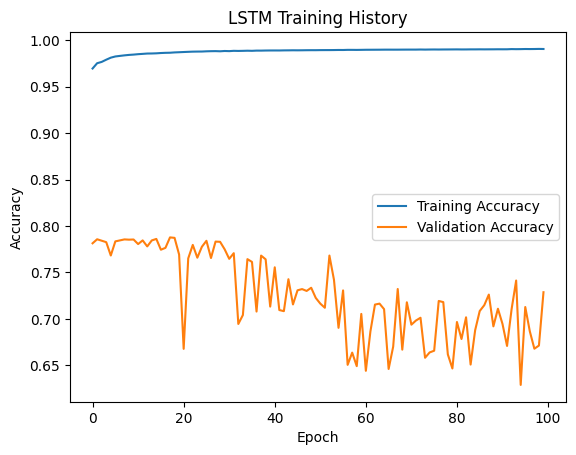

In [54]:
plt.plot(history_rnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("lstm_training_history")

In [ ]:
# Membuat model RNN untuk multi-kelas tanpa data dari Autoencoder
# encoding_dim = 78
# rnn_model = tf.keras.Sequential([
#     layers.Input(shape=(encoding_dim,)),
#     layers.Reshape((encoding_dim, 1)),
#     layers.LSTM(256, return_sequences=True),
#     layers.Dropout(0.4),
#     layers.LSTM(128),
#     layers.Dropout(0.4),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(num_classes, activation='softmax')  # Output layer untuk multi-kelas
# ])

# # Compile RNN
# rnn_model.compile(optimizer='adam',
#                  loss='categorical_crossentropy',
#                  metrics=['accuracy'])

# # Training RNN dengan early stopping
# early_stopping_rnn = tf.keras.callbacks.EarlyStopping(
#     monitor='val_accuracy',
#     patience=5,
#     restore_best_weights=True
# )

# print("\nTraining RNN...")
# history_rnn = rnn_model.fit(X_train, y_train,
#                            epochs=50,
#                            batch_size=512,
#                            validation_split=0.2,
#                            callbacks=[early_stopping_rnn])


In [ ]:
rnn_model.summary()

## Evaluasi Model pada Data Test

In [ ]:
X_test, y_test = transform_data(X_test, y_test, scaler, imputer, le)
X_test_encoded = encoder.predict(X_test)

In [ ]:
Evaluasi model
y_pred = rnn_model.predict(X_test_encoded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Tampilkan hasil evaluasi
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_autoencoder.history['loss'], label='Training Loss')
plt.plot(history_autoencoder.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
plt.plot(history_autoencoder.history['loss'], label='Training Loss')
plt.plot(history_autoencoder.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("ae_plot_history")

In [ ]:
plt.plot(history_rnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("lstm_training_history")

In [ ]:
# # Plot confusion matrix
# plt.figure(figsize=(12, 10))
# cm = confusion_matrix(y_test_classes, y_pred_classes)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=le.classes_,
#             yticklabels=le.classes_)
# plt.title('Confusion Matrix')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.xticks(rotation=45)
# plt.yticks(rotation=45)
# plt.tight_layout()
# plt.show()
# plt.savefig("confusion_matrix")


In [ ]:
# Simpan model
print("\nMenyimpan model...")
autoencoder.save('autoencoder_model.h5')
encoder.save('encoder_model.h5')
rnn_model.save('rnn_model.h5')

In [ ]:
# Simpan label encoder
import joblib
joblib.dump(le, 'label_encoder.joblib')
joblib.dump(scaler, 'scaler.joblib')

---